# Introduction to Time Series Analysis

For a more detailed breakdown of the theory behind the code, check out the [full article](https://blog.paperspace.com/introduction-time-series-analysis) on the Paperspace blog.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


df = pd.read_csv('jena_climate_2009_2016.csv')

time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
series = df['T (degC)']
series.index = time

print(df)

        p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
0         996.52     -8.02    265.40        -8.90   93.30          3.33   
1         996.57     -8.41    265.01        -9.28   93.40          3.23   
2         996.53     -8.51    264.91        -9.31   93.90          3.21   
3         996.51     -8.31    265.12        -9.07   94.20          3.26   
4         996.51     -8.27    265.15        -9.04   94.10          3.27   
...          ...       ...       ...          ...     ...           ...   
420546   1000.07     -4.05    269.10        -8.13   73.10          4.52   
420547    999.93     -3.35    269.81        -8.06   69.71          4.77   
420548    999.82     -3.16    270.01        -8.21   67.91          4.84   
420549    999.81     -4.23    268.94        -8.53   71.80          4.46   
420550    999.82     -4.82    268.36        -8.42   75.70          4.27   

        VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
0               3.1

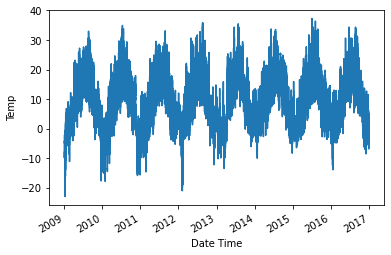

In [16]:
series.plot()
plt.ylabel('Temp')
plt.show()

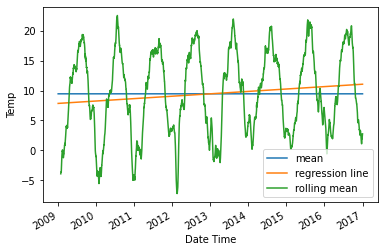

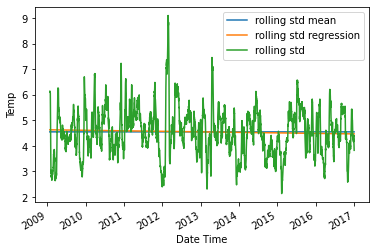

In [17]:
import numpy as np

plt.plot(series.index, np.array([series.mean()] * len(series)))

x = np.arange(len(series))
y = series.values
m, c = np.polyfit(x, y, 1)

plt.plot(series.index, m*x + c)

series.rolling(3600).mean().plot()

plt.legend(['mean', 'regression line', 'rolling mean'])
plt.ylabel('Temp')
plt.show()


roll_std = series.rolling(3600).std()
roll_std.dropna(inplace=True)
plt.plot(roll_std.index, np.array([roll_std.mean()] * len(roll_std)))

x = np.arange(len(roll_std))
y = roll_std.values
m, c = np.polyfit(x, y, 1)

plt.plot(roll_std.index, m*x + c)

roll_std.plot()
plt.legend(['rolling std mean', 'rolling std regression', 'rolling std'])
plt.ylabel('Temp')
plt.show()

In [18]:
def correlation(x, y):
    x_norm = x - x.mean()
    y_norm = y - y.mean()
    return np.sum(x_norm * y_norm) / np.sqrt(np.sum(x_norm ** 2) * np.sum(y_norm ** 2))

In [19]:
def autocorrelation(x, k):
    val_0 = np.sum((x - x.mean()) ** 2) / len(x)
    val_k = np.sum((x[:-k] - x.mean()) * (x[k:] - x.mean())) / len(x)
    return val_k / val_0

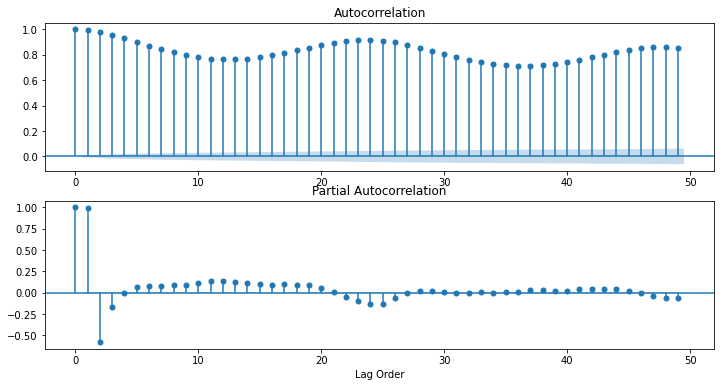

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def get_acf_pacf_plots(df):
    fig, ax = plt.subplots(2, figsize=(12,6))
    plt.xlabel('Lag Order')
    ax[0] = plot_acf(df, ax=ax[0])
    ax[1] = plot_pacf(df, ax=ax[1])

get_acf_pacf_plots(series[5::6])
plt.show()

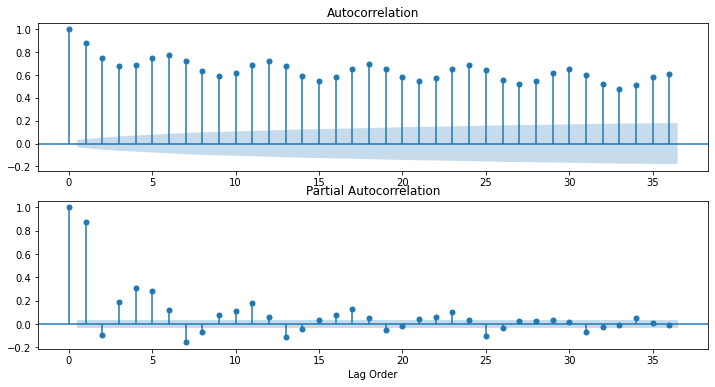

In [21]:
series2 = series[119::120]
get_acf_pacf_plots(series2)
plt.show()

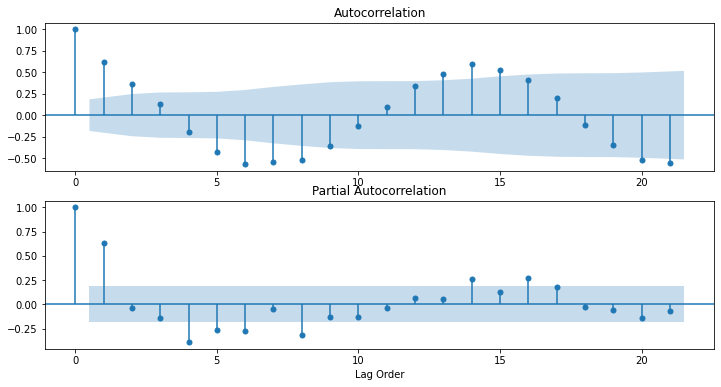

In [22]:
series2 = series2[30::31]
get_acf_pacf_plots(series2)
plt.show()

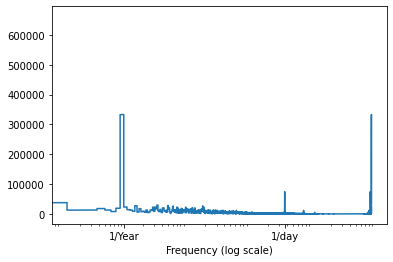

In [23]:
from scipy.fft import fft

fft_vals = fft(series[5::6].values)
f_per_dataset = np.arange(0, len(fft_vals))

n_samples_h = len(series[5::6])

hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft_vals))
plt.xscale('log')
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.show()


In [24]:
from statsmodels.tsa.stattools import adfuller

def test_dickey_fuller_stationarity(df):
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             'Number of Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if dfoutput['Critical Value (1%)'] <  dfoutput['Test Statistic']:
        print('Series is not stationary with 99% confidence. ')
    elif dfoutput['Critical Value (5%)'] < dfoutput['Test Statistic']:
        print('Series is not stationary with 95% confidence. ')
    elif dfoutput['Critical Value (10%)'] < dfoutput['Test Statistic']:
        print('Series is not stationary with 90% confidence. ')
    else:
        print('Series is possibly stationary. ')
    return dfoutput

In [25]:
from statsmodels.tsa.stattools import kpss

def test_kpss(df):
    dftest = kpss(df)
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic',
                                             'p-value',
                                             'Number of Lags Used'])
    for key,value in dftest[3].items():
        dfoutput['Critical Value (%s)'%key] = value
    if abs(dfoutput['Critical Value (1%)']) < abs(dfoutput['Test Statistic']):
        print('Series is not stationary with 99% confidence. ')
    elif abs(dfoutput['Critical Value (5%)']) < abs(dfoutput['Test Statistic']):
        print('Series is not stationary with 95% confidence. ')
    elif abs(dfoutput['Critical Value (10%)']) < abs(dfoutput['Test Statistic']):
        print('Series is not stationary with 90% confidence. ')
    else:
        print('Series is possibly stationary. ')
    return dfoutput

In [26]:
def eliminate_trends(series):
    roll = series.rolling(4).mean()
    avg_diff = (series - roll)/roll
    avg_diff.dropna(inplace=True)
    return avg_diff

diff = eliminate_trends(series[5::6])
print('-------- ADF Test ---------')
out = test_dickey_fuller_stationarity(diff)
print(out)
print('-------- KPSS Test ---------')
out = test_kpss(diff)
print(out)

-------- ADF Test ---------
Series is possibly stationary. 
Test Statistic                  -264.739131
p-value                            0.000000
Number of Lags Used                0.000000
Number of Observations Used    70087.000000
Critical Value (1%)               -3.430443
Critical Value (5%)               -2.861581
Critical Value (10%)              -2.566792
dtype: float64
-------- KPSS Test ---------
Series is possibly stationary. 
Test Statistic            0.302973
p-value                   0.100000
Number of Lags Used      62.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [27]:
def eliminate_linear_trend(series):
    x = np.arange(len(series))
    m, c = np.polyfit(x, series, 1)
    return (series - c) / m
    
diff = eliminate_linear_trend(series[5::6])
print('-------- ADF Test ---------')
out = test_dickey_fuller_stationarity(diff)
print(out)
print('-------- KPSS Test ---------')
out = test_kpss(diff)
out = print(out)

-------- ADF Test ---------
Series is possibly stationary. 
Test Statistic                -8.563581e+00
p-value                        8.564827e-14
Number of Lags Used            6.200000e+01
Number of Observations Used    7.002800e+04
Critical Value (1%)           -3.430443e+00
Critical Value (5%)           -2.861581e+00
Critical Value (10%)          -2.566792e+00
dtype: float64
-------- KPSS Test ---------
Series is not stationary with 99% confidence. 
Test Statistic            1.975914
p-value                   0.010000
Number of Lags Used      62.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [28]:
def difference(series, lag=1):
    differenced = []
    for x in range(lag, len(series)):
        differenced.append(series[x] - series[x - lag])
    return pd.Series(differenced)

diff = difference(series[5::6])
print('-------- ADF Test ---------')
out = test_dickey_fuller_stationarity(diff)
print(out)
print('-------- KPSS Test ---------')
out = test_kpss(diff)
print(out)

-------- ADF Test ---------
Series is possibly stationary. 
Test Statistic                   -41.437843
p-value                            0.000000
Number of Lags Used               62.000000
Number of Observations Used    70027.000000
Critical Value (1%)               -3.430443
Critical Value (5%)               -2.861581
Critical Value (10%)              -2.566792
dtype: float64
-------- KPSS Test ---------
Series is possibly stationary. 
Test Statistic            0.006392
p-value                   0.100000
Number of Lags Used      62.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
